<a href="https://colab.research.google.com/github/6aleb3ilem/Random-Forest-from-scratch/blob/main/Projet_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet de Machine Learning : Prédiction des valeurs commerciales de produits de pêche en Afrique**

# Objectif: Créer un modèle depuis zéro pour prédire les valeurs commerciales
## Spécifications Techniques
- **Dataset** : `Africa_Value.csv` (valeurs en $US, 57 pays, 2000-2015).
- **Modèle** : Random Forest avec 50 arbres, profondeur max 15.
- **Features** : Pays, flux (export/import), produit, année relative, valeur précédente, moyenne mobile 3 ans.
- **Entraînement** : 2000-2012, Test : 2013-2015.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random


plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)


# PARTIE 1: CHARGEMENT ET EXPLORATION DES DONNÉES


In [ ]:
donnees = pd.read_csv('Africa_Value.csv')
print(f"Dimensions du dataset: {donnees.shape}")
print(f"Nombre de pays: {donnees['Land Area'].nunique()}")
print(f"Types de flux commerciaux: {donnees['Trade flow'].unique()}")
print(f"Types de produits: {donnees['Commodity'].unique()}")

# Afficher les premières lignes
print("\nAperçu des données:")
print(donnees.head())

# Statistiques descriptives
print("\nStatistiques des valeurs commerciales (2015):")
print(donnees['2015'].describe())


Dimensions du dataset: (217, 19)
Nombre de pays: 57
Types de flux commerciaux: ['Export' 'Import']
Types de produits: ['Crustaceans' 'Fish']

Aperçu des données:
  Land Area Trade flow    Commodity   2000   2001  2002   2003   2004   2005  \
0   Algeria     Export  Crustaceans   3591   4052  4415   4850   7089   9167   
1   Algeria     Export         Fish    382    585   983    859    530    903   
2   Algeria     Import  Crustaceans     71     44   471    498    903   1178   
3   Algeria     Import         Fish  11990  13600  8206  15345  21798  19350   
4    Angola     Export  Crustaceans   3425   4070  9755   2166   2347   9951   

    2006   2007   2008   2009   2010   2011   2012   2013    2014   2015  
0   8867   8786   8074   5335   3584   4049   2771   2277    2849   2278  
1   1677   1754   3154   2209   1357    443   1039   1755    1558   1486  
2    796   1291   1407   2918   3135   4286   5138   6713    8239   7124  
3  28950  25414  28891  49736  46003  52055  56841  81094

# PARTIE 2: PRÉPARATION DES DONNÉES


In [ ]:

# Transformer les données pour avoir une ligne par année
annees = [str(an) for an in range(2000, 2016)]
donnees_transformees = []

for idx, ligne in donnees.iterrows():
    for annee in annees:
        nouvelle_ligne = {
            'pays': ligne['Land Area'],
            'flux': ligne['Trade flow'],
            'produit': ligne['Commodity'],
            'annee': int(annee),
            'valeur': ligne[annee]
        }
        donnees_transformees.append(nouvelle_ligne)

df = pd.DataFrame(donnees_transformees)
print(f"Nouvelles dimensions après transformation: {df.shape}")

# Gérer les valeurs manquantes (remplacer par 0)
# Dans le commerce, pas de valeur = pas de commerce
df['valeur'] = df['valeur'].fillna(0)
print(f"Valeurs manquantes après traitement: {df['valeur'].isna().sum()}")

# Créer des variables numériques pour les catégories
# On va encoder les variables catégorielles manuellement
encodage_pays = {pays: i for i, pays in enumerate(df['pays'].unique())}
encodage_flux = {'Export': 0, 'Import': 1}
encodage_produit = {'Fish': 0, 'Crustaceans': 1}

df['pays_code'] = df['pays'].map(encodage_pays)
df['flux_code'] = df['flux'].map(encodage_flux)
df['produit_code'] = df['produit'].map(encodage_produit)

print("\nEncodage des variables:")
print(f"Nombre de codes pays: {len(encodage_pays)}")
print(f"Codes flux: {encodage_flux}")
print(f"Codes produit: {encodage_produit}")

Nouvelles dimensions après transformation: (3472, 5)
Valeurs manquantes après traitement: 0

Encodage des variables:
Nombre de codes pays: 57
Codes flux: {'Export': 0, 'Import': 1}
Codes produit: {'Fish': 0, 'Crustaceans': 1}


# PARTIE 3: CRÉATION DE FEATURES SUPPLÉMENTAIRES


In [ ]:
# Ajouter des features temporelles
df['decennie'] = (df['annee'] // 10) * 10
df['annee_relative'] = df['annee'] - 2000

# Calculer des moyennes mobiles par pays/produit/flux
# Cela nous aidera à capturer les tendances
df_sorted = df.sort_values(['pays', 'flux', 'produit', 'annee'])
df['valeur_annee_precedente'] = df_sorted.groupby(['pays', 'flux', 'produit'])['valeur'].shift(1)
df['moyenne_mobile_3ans'] = df_sorted.groupby(['pays', 'flux', 'produit'])['valeur'].rolling(3, min_periods=1).mean().values

df = df.fillna(0)

print("Features créées:")
print(df.columns.tolist())

Features créées:
['pays', 'flux', 'produit', 'annee', 'valeur', 'pays_code', 'flux_code', 'produit_code', 'decennie', 'annee_relative', 'valeur_annee_precedente', 'moyenne_mobile_3ans']


# PARTIE 4: IMPLÉMENTATION


In [ ]:
class NoeudDecision:
    """
    Classe représentant un noeud dans notre arbre de décision
    """
    def __init__(self):
        self.feature = None  # quelle feature on utilise pour diviser
        self.seuil = None    # valeur du seuil
        self.gauche = None   # sous-arbre gauche
        self.droite = None   # sous-arbre droite
        self.valeur = None   # valeur de prédiction (pour les feuilles)

class ArbreDecision:
    """
    Notre implémentation d'un arbre de décision pour la régression
    """
    def __init__(self, profondeur_max=10, min_echantillons_split=20, nb_features_aleatoires=None):
        self.profondeur_max = profondeur_max
        self.min_echantillons_split = min_echantillons_split
        self.nb_features_aleatoires = nb_features_aleatoires
        self.racine = None

    def entrainer(self, X, y):
        """Entraîner l'arbre"""
        self.n_features = X.shape[1]
        if self.nb_features_aleatoires is None:
            # Pour la régression, on prend sqrt(n_features) par défaut
            self.nb_features_aleatoires = int(np.sqrt(self.n_features))
        self.racine = self._construire_arbre(X, y, profondeur=0)

    def _calculer_mse(self, y):
        """Calculer l'erreur quadratique moyenne"""
        if len(y) == 0:
            return 0
        moyenne = np.mean(y)
        return np.mean((y - moyenne) ** 2)

    def _meilleure_division(self, X, y):
        """Trouver la meilleure division pour un ensemble de données"""
        m, n = X.shape
        if m <= 1:
            return None, None

        # MSE du noeud parent
        mse_parent = self._calculer_mse(y)

        # Variables pour stocker la meilleure division
        meilleur_gain = 0
        meilleure_feature = None
        meilleur_seuil = None

        # Sélectionner des features aléatoires
        features_aleatoires = random.sample(range(n), min(self.nb_features_aleatoires, n))

        for feature in features_aleatoires:
            valeurs_uniques = np.unique(X[:, feature])

            # Essayer différents seuils
            for i in range(1, len(valeurs_uniques)):
                seuil = (valeurs_uniques[i-1] + valeurs_uniques[i]) / 2

                # Diviser les données
                indices_gauche = X[:, feature] <= seuil
                indices_droite = X[:, feature] > seuil

                if np.sum(indices_gauche) == 0 or np.sum(indices_droite) == 0:
                    continue

                y_gauche = y[indices_gauche]
                y_droite = y[indices_droite]

                # Calculer le gain d'information
                n_gauche, n_droite = len(y_gauche), len(y_droite)
                mse_gauche = self._calculer_mse(y_gauche)
                mse_droite = self._calculer_mse(y_droite)

                gain = mse_parent - (n_gauche/m * mse_gauche + n_droite/m * mse_droite)

                if gain > meilleur_gain:
                    meilleur_gain = gain
                    meilleure_feature = feature
                    meilleur_seuil = seuil

        return meilleure_feature, meilleur_seuil

    def _construire_arbre(self, X, y, profondeur):
        """Construire l'arbre récursivement"""
        n_echantillons = X.shape[0]

        # Conditions d'arrêt
        if (profondeur >= self.profondeur_max or
            n_echantillons < self.min_echantillons_split):
            noeud_feuille = NoeudDecision()
            noeud_feuille.valeur = np.mean(y)
            return noeud_feuille

        # Trouver la meilleure division
        feature, seuil = self._meilleure_division(X, y)

        if feature is None:
            noeud_feuille = NoeudDecision()
            noeud_feuille.valeur = np.mean(y)
            return noeud_feuille

        # Créer les sous-arbres
        indices_gauche = X[:, feature] <= seuil
        indices_droite = X[:, feature] > seuil

        noeud = NoeudDecision()
        noeud.feature = feature
        noeud.seuil = seuil
        noeud.gauche = self._construire_arbre(X[indices_gauche], y[indices_gauche], profondeur + 1)
        noeud.droite = self._construire_arbre(X[indices_droite], y[indices_droite], profondeur + 1)

        return noeud

    def predire_echantillon(self, x, noeud):
        """Prédire pour un échantillon"""
        if noeud.valeur is not None:
            return noeud.valeur

        if x[noeud.feature] <= noeud.seuil:
            return self.predire_echantillon(x, noeud.gauche)
        else:
            return self.predire_echantillon(x, noeud.droite)

    def predire(self, X):
        """Prédire pour plusieurs échantillons"""
        predictions = []
        for i in range(X.shape[0]):
            pred = self.predire_echantillon(X[i], self.racine)
            predictions.append(pred)
        return np.array(predictions)

class RandomForest:
    """
    Notre implémentation du Random Forest pour la régression
    """
    def __init__(self, n_arbres=100, profondeur_max=10, min_echantillons_split=20,
                 nb_features_aleatoires=None, taille_echantillon=0.8):
        self.n_arbres = n_arbres
        self.profondeur_max = profondeur_max
        self.min_echantillons_split = min_echantillons_split
        self.nb_features_aleatoires = nb_features_aleatoires
        self.taille_echantillon = taille_echantillon
        self.arbres = []

    def entrainer(self, X, y):
        """Entraîner la forêt"""
        print(f"Entraînement de {self.n_arbres} arbres...")

        for i in range(self.n_arbres):
            # Bootstrap sampling
            n_echantillons = int(len(X) * self.taille_echantillon)
            indices = np.random.choice(len(X), n_echantillons, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]

            # Créer et entraîner un arbre
            arbre = ArbreDecision(
                profondeur_max=self.profondeur_max,
                min_echantillons_split=self.min_echantillons_split,
                nb_features_aleatoires=self.nb_features_aleatoires
            )
            arbre.entrainer(X_bootstrap, y_bootstrap)
            self.arbres.append(arbre)

            # Afficher la progression
            if (i + 1) % 20 == 0:
                print(f"  {i + 1} arbres entraînés...")

    def predire(self, X):
        """Prédire en moyennant les prédictions de tous les arbres"""
        predictions_arbres = []
        for arbre in self.arbres:
            pred = arbre.predire(X)
            predictions_arbres.append(pred)

        # Moyenne des prédictions
        predictions = np.mean(predictions_arbres, axis=0)
        return predictions

# PARTIE 5: PRÉPARATION POUR L'ENTRAÎNEMENT


In [ ]:
# Sélectionner les features pour le modèle
features = ['pays_code', 'flux_code', 'produit_code', 'annee_relative',
            'valeur_annee_precedente', 'moyenne_mobile_3ans']

X = df[features].values
y = df['valeur'].values

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

# Diviser en train/test (80/20)
# On va prendre les années 2000-2012 pour l'entraînement et 2013-2015 pour le test
df_train = df[df['annee'] <= 2012]
df_test = df[df['annee'] > 2012]

X_train = df_train[features].values
y_train = df_train['valeur'].values
X_test = df_test[features].values
y_test = df_test['valeur'].values

print(f"\nTaille ensemble d'entraînement: {len(X_train)}")
print(f"Taille ensemble de test: {len(X_test)}")

Shape de X: (3472, 6)
Shape de y: (3472,)

Taille ensemble d'entraînement: 2821
Taille ensemble de test: 651


# PARTIE 6: ENTRAÎNEMENT DU MODÈLE


In [ ]:
foret = RandomForest(
    n_arbres=50,  # pour éviter l'overfitting
    profondeur_max=15,
    min_echantillons_split=10,
    nb_features_aleatoires=3,
    taille_echantillon=0.7
)

foret.entrainer(X_train, y_train)

Entraînement de 50 arbres...
  20 arbres entraînés...
  40 arbres entraînés...


# PARTIE 7: ÉVALUATION


In [ ]:
# Prédictions sur l'ensemble de test
predictions_test = foret.predire(X_test)

# Calculer les métriques
def calculer_metriques(y_vrai, y_pred):
    """Calculer différentes métriques d'évaluation"""
    # Erreur absolue moyenne
    mae = np.mean(np.abs(y_vrai - y_pred))

    # Erreur quadratique moyenne
    mse = np.mean((y_vrai - y_pred) ** 2)
    rmse = np.sqrt(mse)

    # R²
    ss_tot = np.sum((y_vrai - np.mean(y_vrai)) ** 2)
    ss_res = np.sum((y_vrai - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # MAPE (Mean Absolute Percentage Error)
    # On évite la division par zéro
    mask = y_vrai != 0
    mape = np.mean(np.abs((y_vrai[mask] - y_pred[mask]) / y_vrai[mask])) * 100

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

metriques = calculer_metriques(y_test, predictions_test)

print("Métriques de performance:")
print(f"MAE (Erreur Absolue Moyenne): ${metriques['MAE']:.2f}")
print(f"RMSE (Racine de l'Erreur Quadratique Moyenne): ${metriques['RMSE']:.2f}")
print(f"R² (Coefficient de détermination): {metriques['R²']:.4f}")
print(f"MAPE (Erreur en Pourcentage): {metriques['MAPE']:.2f}%")

Métriques de performance:
MAE (Erreur Absolue Moyenne): $6319.65
RMSE (Racine de l'Erreur Quadratique Moyenne): $20171.78
R² (Coefficient de détermination): 0.9784
MAPE (Erreur en Pourcentage): 146.91%


# PARTIE 8: ANALYSE DES RÉSULTATS


In [ ]:
resultats = df_test.copy()
resultats['predictions'] = predictions_test
resultats['erreur'] = resultats['valeur'] - resultats['predictions']
resultats['erreur_pct'] = np.where(resultats['valeur'] != 0,
                                   (resultats['erreur'] / resultats['valeur']) * 100,
                                   0)

print("\nTop 10 des meilleures prédictions:")
meilleures = resultats.nsmallest(10, 'erreur_pct')[['pays', 'flux', 'produit', 'annee', 'valeur', 'predictions']]
print(meilleures.to_string(index=False))

#  type de flux
print("\nPerformance par type de flux:")
for flux in ['Export', 'Import']:
    subset = resultats[resultats['flux'] == flux]
    mae_flux = np.mean(np.abs(subset['erreur']))
    print(f"{flux}: MAE = ${mae_flux:.2f}")

#  par produit
print("\nPerformance par type de produit:")
for produit in ['Fish', 'Crustaceans']:
    subset = resultats[resultats['produit'] == produit]
    mae_produit = np.mean(np.abs(subset['erreur']))
    print(f"{produit}: MAE = ${mae_produit:.2f}")


Top 10 des meilleures prédictions:
                 pays   flux     produit  annee  valeur  predictions
Sao Tome and Principe Export        Fish   2013       1   198.625620
Sao Tome and Principe Export        Fish   2014       3   200.242995
Sao Tome and Principe Export        Fish   2015       4   200.960151
            Swaziland Export        Fish   2014       5   235.181734
                Gabon Export Crustaceans   2014       6   231.209369
             Djibouti Export        Fish   2014       1    32.261520
           Madagascar Import Crustaceans   2014      10   233.248707
                Benin Export Crustaceans   2013       3    67.490959
               Guinea Export Crustaceans   2015       5   111.509990
                Benin Import Crustaceans   2015       1    18.382393

Performance par type de flux:
Export: MAE = $6612.22
Import: MAE = $6050.39

Performance par type de produit:
Fish: MAE = $10586.52
Crustaceans: MAE = $1597.10


# PARTIE 9: VISUALISATIONS


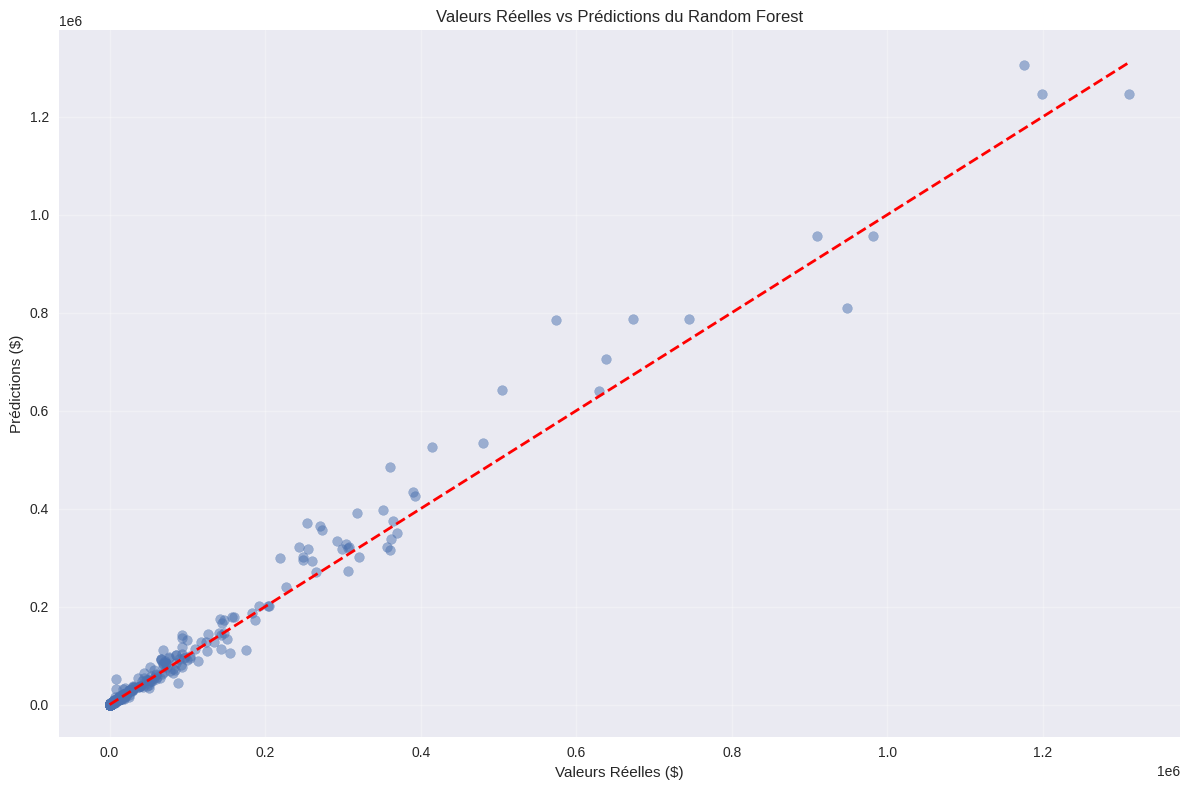

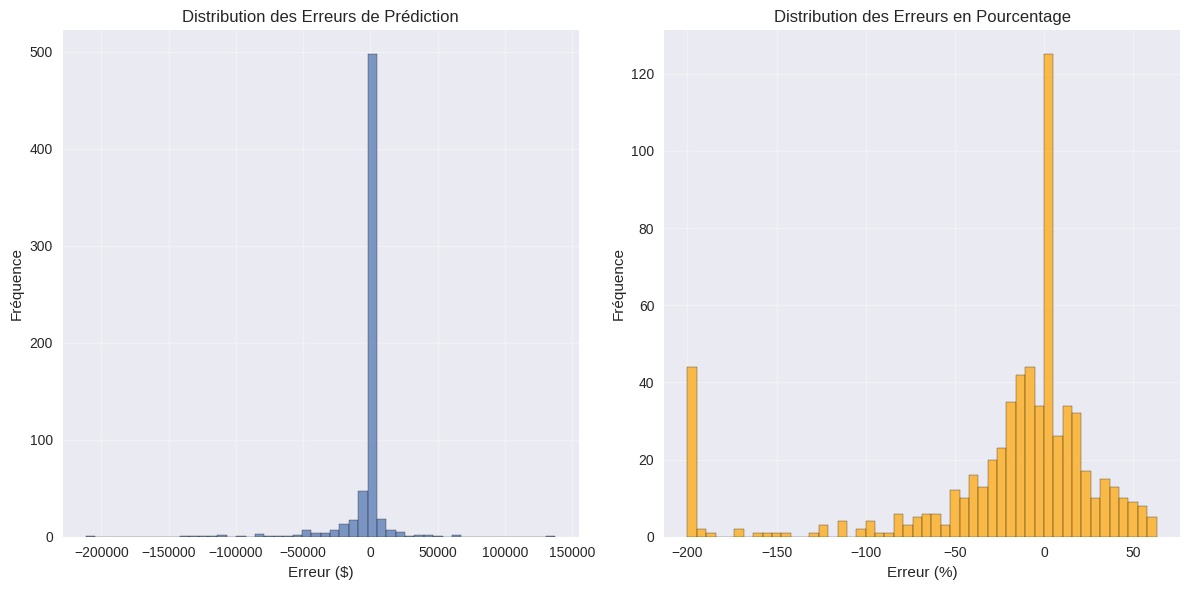

<ipython-input-12-c0c03c9bb016>:48: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


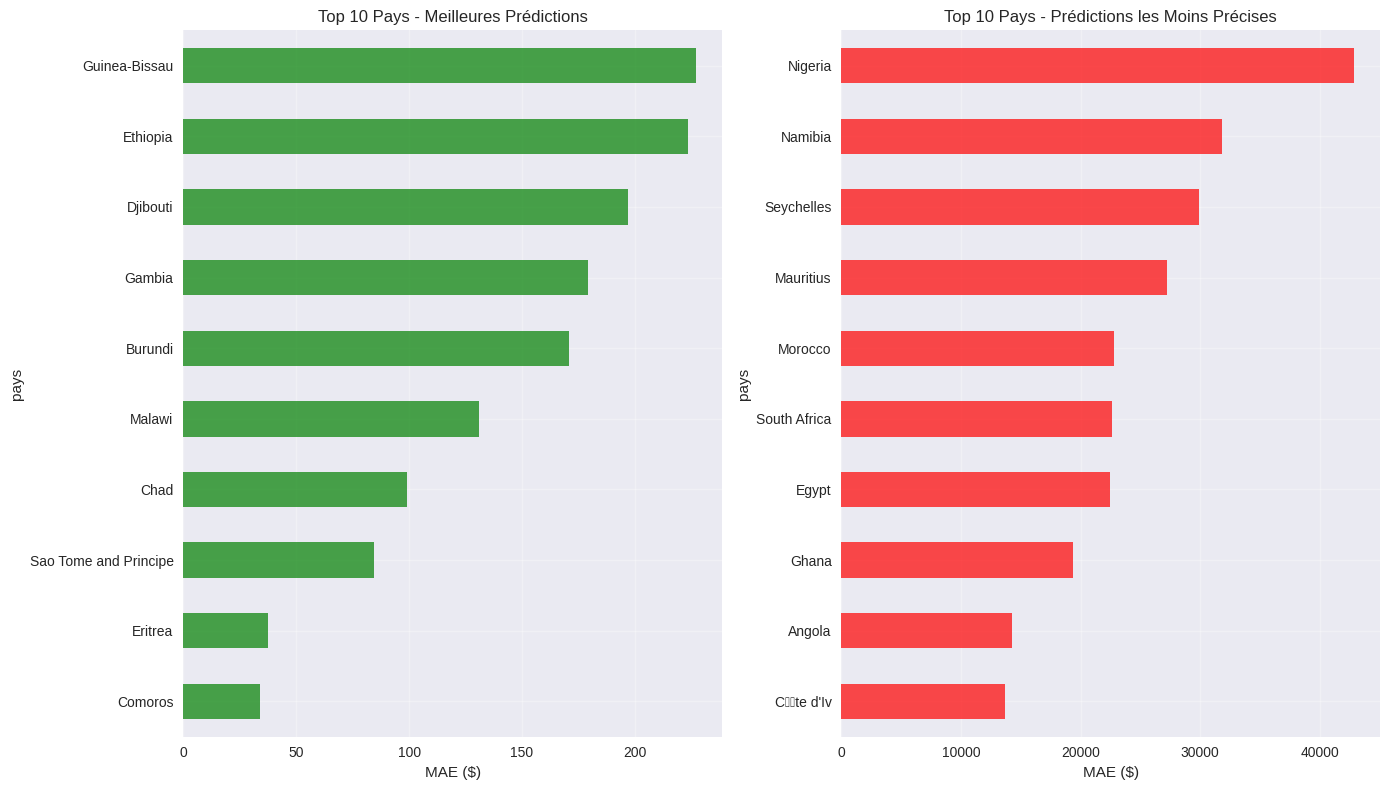

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test, predictions_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs Réelles ($)')
plt.ylabel('Prédictions ($)')
plt.title('Valeurs Réelles vs Prédictions du Random Forest')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Fig 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(resultats['erreur'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Erreur ($)')
plt.ylabel('Fréquence')
plt.title('Distribution des Erreurs de Prédiction')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# pour une meilleure visualisation
erreurs_pct_limitees = resultats['erreur_pct'].clip(-200, 200)
plt.hist(erreurs_pct_limitees, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Erreur (%)')
plt.ylabel('Fréquence')
plt.title('Distribution des Erreurs en Pourcentage')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Fig 3
plt.figure(figsize=(14, 8))
mae_par_pays = resultats.groupby('pays')['erreur'].apply(lambda x: np.mean(np.abs(x))).sort_values()
top_pays = mae_par_pays.head(10)
bottom_pays = mae_par_pays.tail(10)

plt.subplot(1, 2, 1)
top_pays.plot(kind='barh', color='green', alpha=0.7)
plt.xlabel('MAE ($)')
plt.title('Top 10 Pays - Meilleures Prédictions')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
bottom_pays.plot(kind='barh', color='red', alpha=0.7)
plt.xlabel('MAE ($)')
plt.title('Top 10 Pays - Prédictions les Moins Précises')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# PARTIE 10: PREDICTIONS
pour 2016-2017

In [ ]:
donnees_futures = []

for pays in df['pays'].unique():
    for flux in df['flux'].unique():
        for produit in df['produit'].unique():
            # Récupérer les données historiques
            historique = df[(df['pays'] == pays) &
                           (df['flux'] == flux) &
                           (df['produit'] == produit)].sort_values('annee')

            if len(historique) > 0:
                # Pour 2016
                valeur_2015 = historique[historique['annee'] == 2015]['valeur'].values
                valeur_2015 = valeur_2015[0] if len(valeur_2015) > 0 else 0

                moyenne_3_dernieres = historique.tail(3)['valeur'].mean()

                nouvelle_ligne_2016 = {
                    'pays': pays,
                    'flux': flux,
                    'produit': produit,
                    'annee': 2016,
                    'pays_code': encodage_pays[pays],
                    'flux_code': encodage_flux[flux],
                    'produit_code': encodage_produit[produit],
                    'annee_relative': 16,
                    'valeur_annee_precedente': valeur_2015,
                    'moyenne_mobile_3ans': moyenne_3_dernieres
                }
                donnees_futures.append(nouvelle_ligne_2016)

df_futur = pd.DataFrame(donnees_futures)
X_futur = df_futur[features].values

# Faire les prédictions
predictions_2016 = foret.predire(X_futur)
df_futur['predictions'] = predictions_2016

# Afficher quelques prédictions
print("\nQuelques prédictions pour 2016:")
print("\nTop 10 des plus grandes valeurs prédites:")
top_predictions = df_futur.nlargest(10, 'predictions')[['pays', 'flux', 'produit', 'predictions']]
for idx, row in top_predictions.iterrows():
    print(f"{row['pays']} - {row['flux']} - {row['produit']}: ${row['predictions']:.2f}")

#  tendances par region
print("\nTendances globales prédites pour 2016:")
print(f"Total des exportations prédites: ${df_futur[df_futur['flux'] == 'Export']['predictions'].sum():,.2f}")
print(f"Total des importations prédites: ${df_futur[df_futur['flux'] == 'Import']['predictions'].sum():,.2f}")



Quelques prédictions pour 2016:

Top 10 des plus grandes valeurs prédites:
Nigeria - Import - Fish: $1246736.26
Morocco - Export - Fish: $957385.85
Namibia - Export - Fish: $757586.19
Egypt - Import - Fish: $706009.17
Seychelles - Export - Fish: $485567.83
C��te d'Iv - Import - Fish: $434483.35
Mauritius - Export - Fish: $335581.79
Cameroon - Import - Fish: $333855.25
South Africa - Export - Fish: $324273.12
Ghana - Import - Fish: $318499.87

Tendances globales prédites pour 2016:
Total des exportations prédites: $4,944,132.20
Total des importations prédites: $5,806,303.48


# CONCLUSION


In [ ]:
print(f"""
- R² de {metriques['R²']:.4f},
- MAE de ${metriques['MAE']:.2f}
""")


- R² de 0.9784, 
- MAE de $6319.65

